In [2]:
import pandas as pd
import numpy as np

# 1. Chargement des fichiers
stocks_df = pd.read_csv('../base/stocksV2.csv', sep=';')
exped_df = pd.read_csv('../base/expeditionsV2.csv', sep=';')

# 2. Aperçu des données
print("Stocks:\n", stocks_df.head(), "\n")
print("Expéditions:\n", exped_df.head(), "\n")

# 3. Infos et types
print(stocks_df.info())
print(exped_df.info())



Stocks:
          date id_produit entrepot  niveau_stock
0  01/06/2024     P00001     Lyon            88
1  22/04/2024     P00001    Paris           141
2  25/09/2024     P00002     Lyon           286
3  18/02/2024     P00003    Paris           177
4  13/07/2024     P00003     Lyon            95 

Expéditions:
   id_expedition id_commande id_produit  quantité   entrepôt date_expedition  \
0     SHP000001     O000001     P00413         2  Marseille      2024-09-09   
1     SHP000002     O000002     P00778        15       Lyon      2024-11-16   
2     SHP000003     O000004     P00535         8       Lyon      2024-11-06   
3     SHP000004     O000006     P00898         3      Paris      2024-01-26   
4     SHP000005     O000007     P00445         1       Lyon      2024-02-18   

  date_livraison transporteur  coût_transport  délai_livraison  
0     2024-09-15          UPS           11.62                6  
1     2024-11-23   Chronopost           13.61                7  
2     2024-11-09 

In [3]:

# 4. Valeurs manquantes
print("Valeurs manquantes dans stocks :\n", stocks_df.isnull().sum())
print("Valeurs manquantes dans expéditions :\n", exped_df.isnull().sum())


Valeurs manquantes dans stocks :
 date            0
id_produit      0
entrepot        0
niveau_stock    0
dtype: int64
Valeurs manquantes dans expéditions :
 id_expedition      0
id_commande        0
id_produit         0
quantité           0
entrepôt           0
date_expedition    0
date_livraison     0
transporteur       0
coût_transport     0
délai_livraison    0
dtype: int64


In [4]:

exped_df['date_expedition'] = pd.to_datetime(exped_df['date_expedition'], errors='coerce')
exped_df['date_livraison']=pd.to_datetime(exped_df['date_livraison'],errors='coerce')
stocks_df['date']=pd.to_datetime(stocks_df['date'],errors='coerce')
# 5. Doublons
stocks_df.drop_duplicates(inplace=True)
exped_df.drop_duplicates(inplace=True)


In [5]:
stocks_df.info(),exped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          664 non-null    datetime64[ns]
 1   id_produit    1706 non-null   object        
 2   entrepot      1706 non-null   object        
 3   niveau_stock  1706 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 53.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42404 entries, 0 to 42403
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_expedition    42404 non-null  object        
 1   id_commande      42404 non-null  object        
 2   id_produit       42404 non-null  object        
 3   quantité         42404 non-null  int64         
 4   entrepôt         42404 non-null  object        
 5   date_expedition  42404 non-null  dateti

(None, None)

In [6]:

# 6. Valeurs aberrantes (z-score simple sur les colonnes numériques)
from scipy.stats import zscore

for col in ['niveau_stock', 'quantité', 'coût_transport','delai_livraison']:
    if col in stocks_df.columns:
        stocks_df = stocks_df[(np.abs(zscore(stocks_df[col])) < 3)]
    if col in exped_df.columns:
        exped_df = exped_df[(np.abs(zscore(exped_df[col])) < 3)]


In [7]:

# 8. Fusion possible si nécessaire par id_produit
merged_df = pd.merge(stocks_df, exped_df, on='id_produit', how='left')


In [8]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Configuration pour l'affichage des graphiques en français
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'

# Chargement des données
stocks_df = pd.read_csv('../base/stocksV2.csv', sep=';')
expeditions_df = pd.read_csv('../base/expeditionsV2.csv', sep=';')

# Conversion des dates
stocks_df['date'] = pd.to_datetime(stocks_df['date'], format='%d/%m/%Y')
expeditions_df['date_expedition'] = pd.to_datetime(expeditions_df['date_expedition'])
expeditions_df['date_livraison'] = pd.to_datetime(expeditions_df['date_livraison'])

# Vérification des données manquantes
print("Valeurs manquantes dans les stocks:", stocks_df.isnull().sum().sum())
print("Valeurs manquantes dans les expéditions:", expeditions_df.isnull().sum().sum())

# Création de variables temporelles utiles
stocks_df['mois'] = stocks_df['date'].dt.month
stocks_df['jour_semaine'] = stocks_df['date'].dt.dayofweek
stocks_df['trimestre'] = stocks_df['date'].dt.quarter

expeditions_df['mois_expedition'] = expeditions_df['date_expedition'].dt.month
expeditions_df['jour_semaine_expedition'] = expeditions_df['date_expedition'].dt.dayofweek
expeditions_df['trimestre'] = expeditions_df['date_expedition'].dt.quarter

# Calcul du délai réel entre expédition et livraison
expeditions_df['delai_reel'] = (expeditions_df['date_livraison'] - expeditions_df['date_expedition']).dt.days
expeditions_df['ecart_delai'] = expeditions_df['delai_reel'] - expeditions_df['délai_livraison']

# Calcul du coût par unité expédiée
expeditions_df['cout_par_unite'] = expeditions_df['coût_transport'] / expeditions_df['quantité']


Valeurs manquantes dans les stocks: 0
Valeurs manquantes dans les expéditions: 0


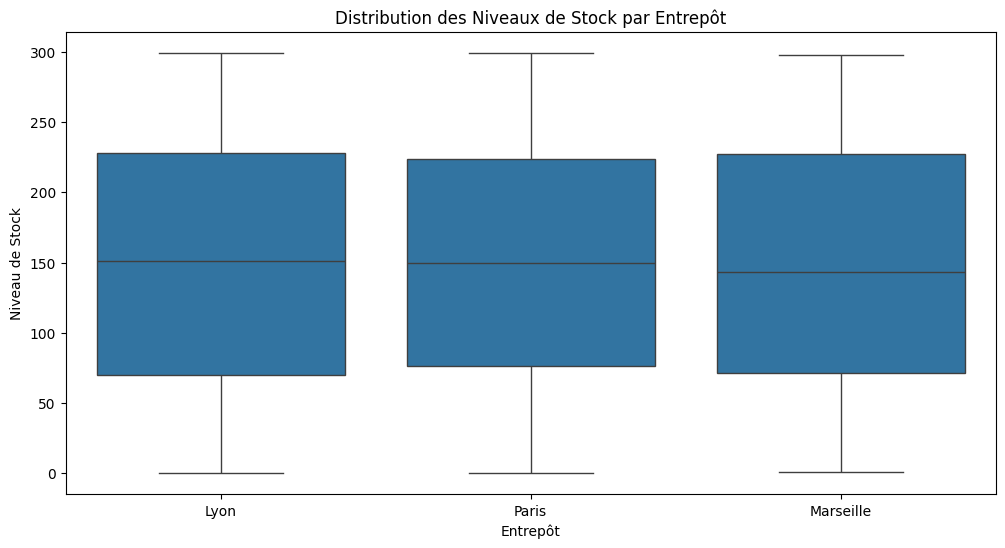

C:\Users\Djo\AppData\Local\Temp\ipykernel_10584\2792303446.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_mensuel = stocks_df.groupby(['entrepot', pd.Grouper(key='date', freq='M')])['niveau_stock'].mean().reset_index()


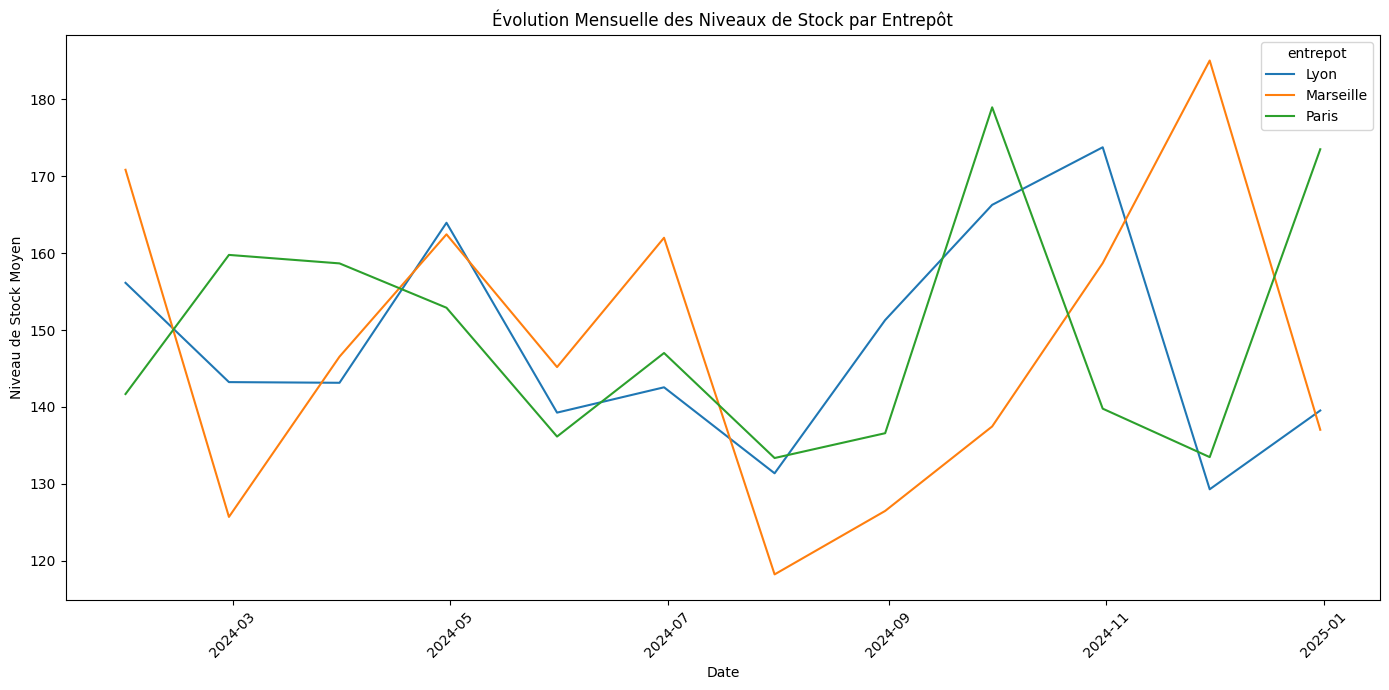

Produits en situation de stock critique (<20 unités):
     id_produit   entrepot  niveau_stock
642      P00377       Lyon             0
1286     P00758      Paris             0
1152     P00678       Lyon             0
543      P00318       Lyon             0
1150     P00676       Lyon             0
957      P00567      Paris             0
1185     P00698      Paris             0
1357     P00797  Marseille             1
249      P00148       Lyon             1
574      P00338      Paris             1


In [9]:
# Analyse des niveaux de stock par entrepôt
plt.figure(figsize=(12, 6))
sns.boxplot(x='entrepot', y='niveau_stock', data=stocks_df)
plt.title('Distribution des Niveaux de Stock par Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Niveau de Stock')
plt.show()

# Évolution des niveaux de stock moyens au fil du temps
stock_mensuel = stocks_df.groupby(['entrepot', pd.Grouper(key='date', freq='M')])['niveau_stock'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='niveau_stock', hue='entrepot', data=stock_mensuel)
plt.title('Évolution Mensuelle des Niveaux de Stock par Entrepôt')
plt.xlabel('Date')
plt.ylabel('Niveau de Stock Moyen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identification des produits avec des niveaux de stock critiques
stock_actuel = stocks_df.sort_values('date').drop_duplicates(subset=['id_produit', 'entrepot'], keep='last')
stock_critique = stock_actuel[stock_actuel['niveau_stock'] < 20].sort_values('niveau_stock')

print("Produits en situation de stock critique (<20 unités):")
print(stock_critique[['id_produit', 'entrepot', 'niveau_stock']].head(10))


## Analyse Expeditions

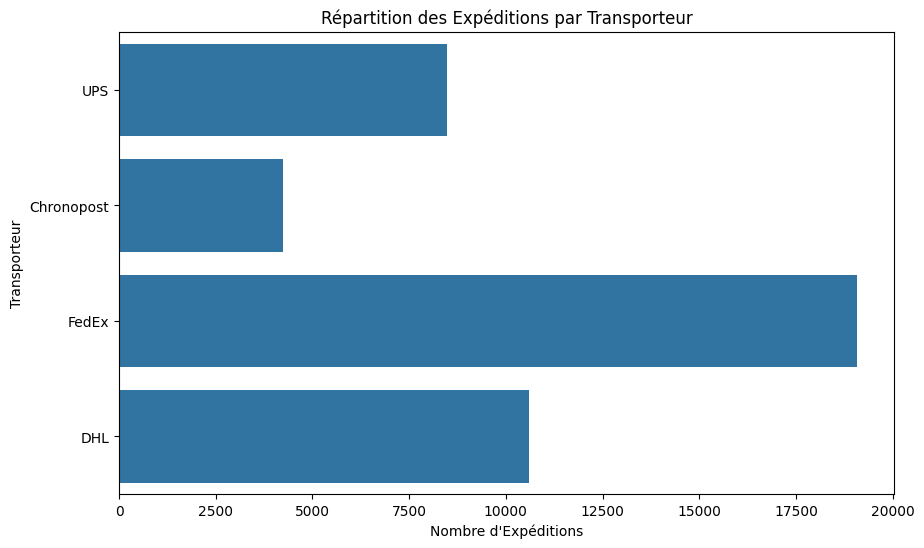

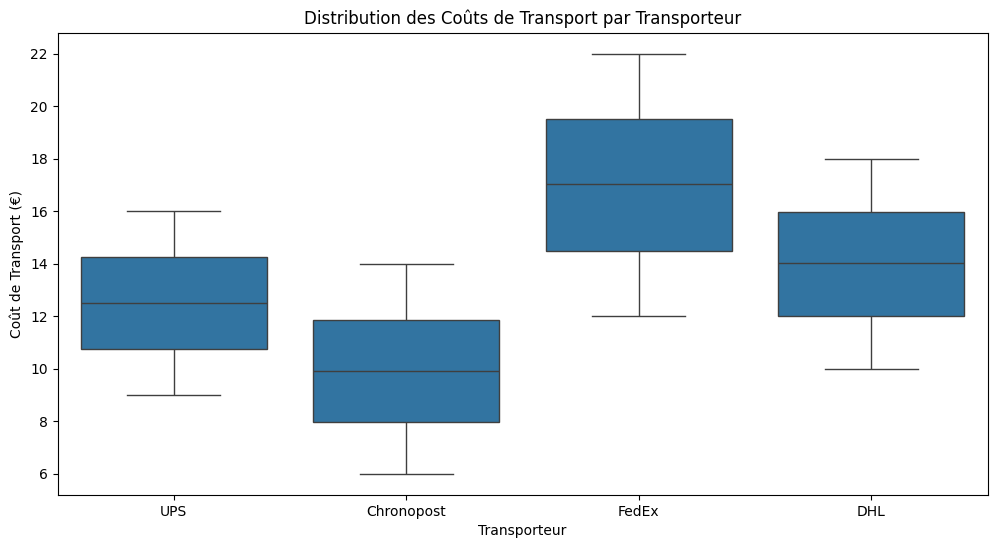

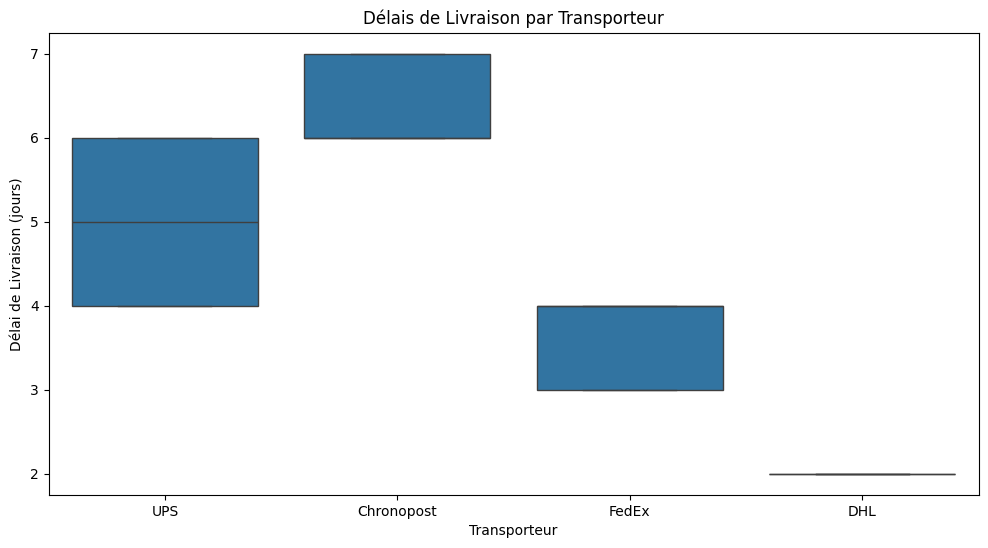

C:\Users\Djo\AppData\Local\Temp\ipykernel_10584\3751547420.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expeditions_mensuelles = expeditions_df.groupby([pd.Grouper(key='date_expedition', freq='M')])['quantité'].sum().reset_index()


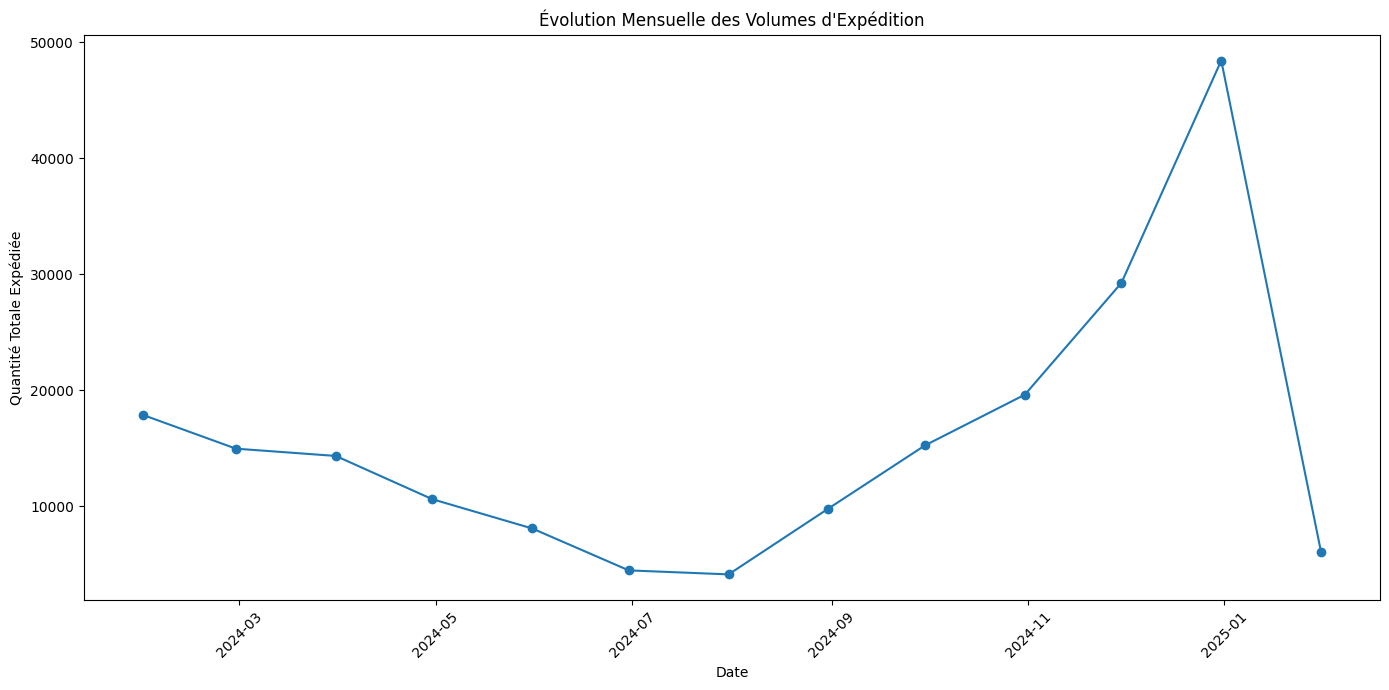

In [10]:
# Distribution des expéditions par transporteur
plt.figure(figsize=(10, 6))
sns.countplot(y='transporteur', data=expeditions_df)
plt.title('Répartition des Expéditions par Transporteur')
plt.xlabel('Nombre d\'Expéditions')
plt.ylabel('Transporteur')
plt.show()

# Analyse des coûts de transport par transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='coût_transport', data=expeditions_df)
plt.title('Distribution des Coûts de Transport par Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Coût de Transport (€)')
plt.show()

# Analyse des délais de livraison par transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='délai_livraison', data=expeditions_df)
plt.title('Délais de Livraison par Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Délai de Livraison (jours)')
plt.show()

# Évolution des volumes d'expédition dans le temps
expeditions_mensuelles = expeditions_df.groupby([pd.Grouper(key='date_expedition', freq='M')])['quantité'].sum().reset_index()
plt.figure(figsize=(14, 7))
plt.plot(expeditions_mensuelles['date_expedition'], expeditions_mensuelles['quantité'], marker='o')
plt.title('Évolution Mensuelle des Volumes d\'Expédition')
plt.xlabel('Date')
plt.ylabel('Quantité Totale Expédiée')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Stock et Expeditions 

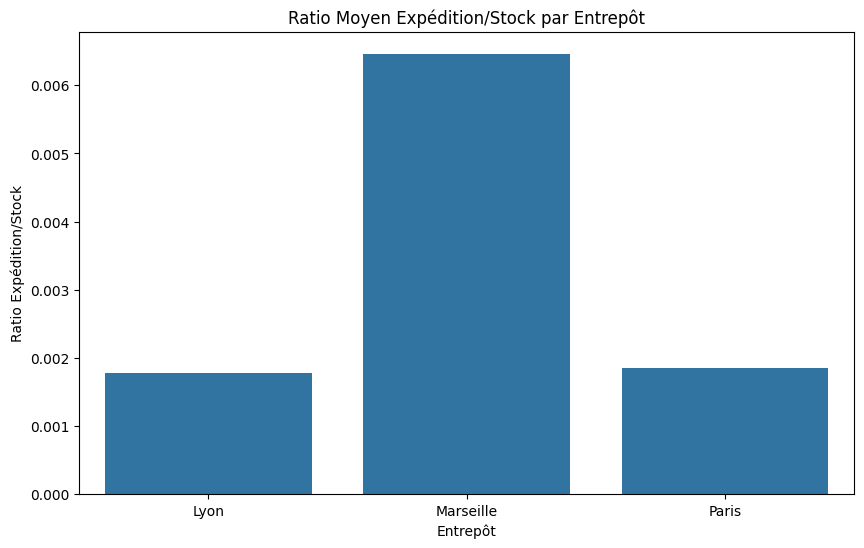

Produits à faible rotation (ratio < 0.05): 987
    id_produit  ratio_exp_stock
0       P00001              0.0
657     P00658              0.0
658     P00659              0.0
659     P00660              0.0
660     P00661              0.0
661     P00662              0.0
662     P00663              0.0
663     P00664              0.0
664     P00665              0.0
665     P00666              0.0
Produits à forte rotation (ratio > 0.5): 0
Empty DataFrame
Columns: [id_produit, ratio_exp_stock]
Index: []


In [11]:
# Création d'un dataframe des expéditions quotidiennes
expeditions_daily = expeditions_df.groupby(['date_expedition', 'id_produit', 'entrepôt'])['quantité'].sum().reset_index()
expeditions_daily = expeditions_daily.rename(columns={'date_expedition': 'date', 'entrepôt': 'entrepot'})

# Jointure avec les données de stock
stock_exp_df = pd.merge(stocks_df, expeditions_daily, on=['date', 'id_produit', 'entrepot'], how='left')
stock_exp_df['quantité'] = stock_exp_df['quantité'].fillna(0)

# Calcul du ratio d'expédition par rapport au stock
stock_exp_df['ratio_exp_stock'] = stock_exp_df['quantité'] / stock_exp_df['niveau_stock']
stock_exp_df['ratio_exp_stock'] = stock_exp_df['ratio_exp_stock'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Analyse du ratio moyen par entrepôt
ratio_entrepot = stock_exp_df.groupby('entrepot')['ratio_exp_stock'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='entrepot', y='ratio_exp_stock', data=ratio_entrepot)
plt.title('Ratio Moyen Expédition/Stock par Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Ratio Expédition/Stock')
plt.show()

# Identification des produits à faible rotation (ratio < 0.05)
rotation_produits = stock_exp_df.groupby('id_produit')['ratio_exp_stock'].mean().reset_index()
low_rotation = rotation_produits[rotation_produits['ratio_exp_stock'] < 0.05].sort_values('ratio_exp_stock')
print(f"Produits à faible rotation (ratio < 0.05): {len(low_rotation)}")
print(low_rotation.head(10))

# Identification des produits à forte rotation (ratio > 0.5)
high_rotation = rotation_produits[rotation_produits['ratio_exp_stock'] > 0.5].sort_values('ratio_exp_stock', ascending=False)
print(f"Produits à forte rotation (ratio > 0.5): {len(high_rotation)}")
print(high_rotation.head(10))


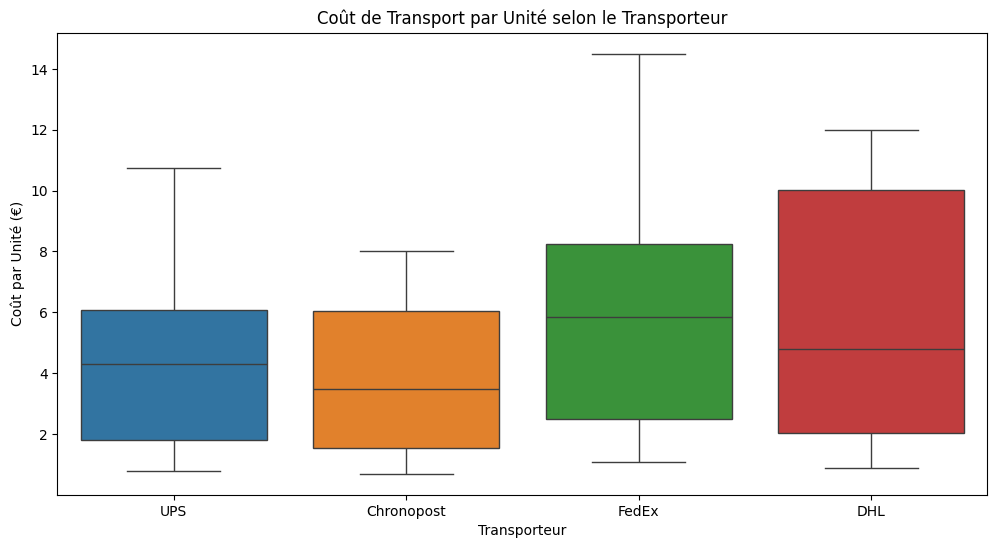

In [13]:
# Analyse du coût par unité selon le transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='cout_par_unite', data=expeditions_df,hue='transporteur')
plt.title('Coût de Transport par Unité selon le Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Coût par Unité (€)')
plt.show()



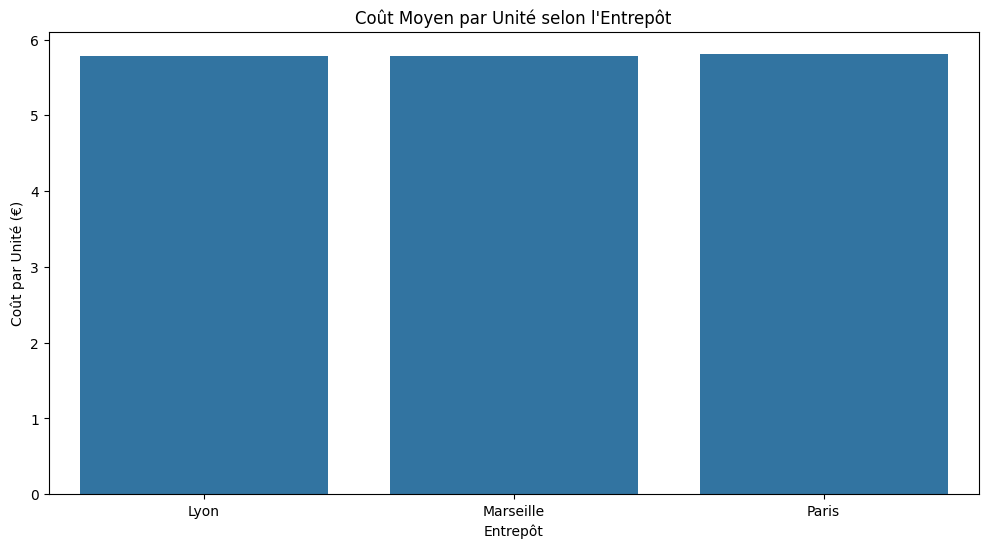

In [14]:
# Analyse des coûts par entrepôt
cout_entrepot = expeditions_df.groupby('entrepôt').agg({
    'coût_transport': 'mean',
    'cout_par_unite': 'mean',
    'délai_livraison': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='entrepôt', y='cout_par_unite', data=cout_entrepot)
plt.title('Coût Moyen par Unité selon l\'Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Coût par Unité (€)')
plt.show()

# Analyse des combinaisons entrepôt/transporteur
combo_efficacite = expeditions_df.groupby(['entrepôt', 'transporteur']).agg({
    'cout_par_unite': 'mean',
    'délai_livraison': 'mean',
    'quantité': 'sum'
}).reset_index()


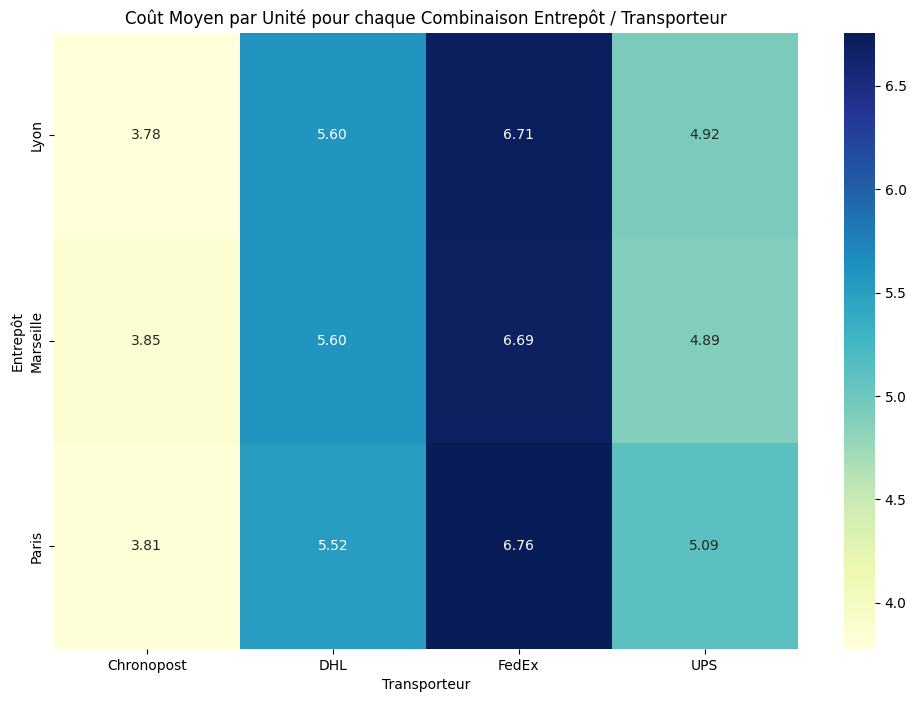

In [16]:

# Visualisation sous forme de heatmap
pivot_cout = combo_efficacite.pivot(index='entrepôt', columns='transporteur', values='cout_par_unite')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_cout, annot=True, fmt='.2f', cmap='YlGnBu')

plt.title('Coût Moyen par Unité pour chaque Combinaison Entrepôt / Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Entrepôt')
plt.show()

In [17]:

# Identification des combinaisons optimales
transporteur_optimal = combo_efficacite.loc[combo_efficacite.groupby('entrepôt')['cout_par_unite'].idxmin()]
print("Transporteur le plus économique par entrepôt:")
print(transporteur_optimal[['entrepôt', 'transporteur', 'cout_par_unite', 'délai_livraison']])


Transporteur le plus économique par entrepôt:
    entrepôt transporteur  cout_par_unite  délai_livraison
0       Lyon   Chronopost        3.777328         6.500000
4  Marseille   Chronopost        3.850119         6.489796
8      Paris   Chronopost        3.809190         6.502460
